<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse throigh the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install osmnx==0.13.0 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 21 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-underscore all 1.8.3~dfsg-1 [59.9 kB]
Get:4 htt

In [29]:
import os,os.path
from glob import glob
from shutil import copyfile

import fiona
from shapely.geometry import shape, mapping, Point
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from numpy import arange

# optimization-related
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/My\ Drive/StreetPsych

Chicago  HydePark  key.txt


In [ ]:
#place_name = "Chicago, Illinois, USA"
place_name = "Hyde Park, Chicago, Illinois, USA"
graph = ox.graph_from_place(place_name, network_type='walk')

In [6]:
location = 'HydePark' # 'Chicago'

#ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/Chicago')
#ox.save_graph_shapefile(graph, filepath='drive/My Drive/StreetPsych/' + location)

In [7]:
files = glob("drive/My Drive/StreetPsych/" + location + "/*")
print(files)

['drive/My Drive/StreetPsych/HydePark/nodes.shx', 'drive/My Drive/StreetPsych/HydePark/nodes.cpg', 'drive/My Drive/StreetPsych/HydePark/nodes.dbf', 'drive/My Drive/StreetPsych/HydePark/nodes.shp', 'drive/My Drive/StreetPsych/HydePark/nodes.prj', 'drive/My Drive/StreetPsych/HydePark/edges.prj', 'drive/My Drive/StreetPsych/HydePark/edges.dbf', 'drive/My Drive/StreetPsych/HydePark/edges.shx', 'drive/My Drive/StreetPsych/HydePark/edges.cpg', 'drive/My Drive/StreetPsych/HydePark/edges.shp', 'drive/My Drive/StreetPsych/HydePark/seed_HydePark.csv', 'drive/My Drive/StreetPsych/HydePark/gsv_seed_HydePark.csv']


In [8]:
if not os.path.exists('source'):
  os.mkdir('source')

In [9]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'source/' + os.path.basename(f))

drive/My Drive/StreetPsych/HydePark/nodes.shx
drive/My Drive/StreetPsych/HydePark/nodes.cpg
drive/My Drive/StreetPsych/HydePark/nodes.dbf
drive/My Drive/StreetPsych/HydePark/nodes.shp
drive/My Drive/StreetPsych/HydePark/nodes.prj
drive/My Drive/StreetPsych/HydePark/edges.prj
drive/My Drive/StreetPsych/HydePark/edges.dbf
drive/My Drive/StreetPsych/HydePark/edges.shx
drive/My Drive/StreetPsych/HydePark/edges.cpg
drive/My Drive/StreetPsych/HydePark/edges.shp
drive/My Drive/StreetPsych/HydePark/seed_HydePark.csv
drive/My Drive/StreetPsych/HydePark/gsv_seed_HydePark.csv


In [10]:
!ls source

edges.cpg  edges.shp		  nodes.cpg  nodes.shp
edges.dbf  edges.shx		  nodes.dbf  nodes.shx
edges.prj  gsv_seed_HydePark.csv  nodes.prj  seed_HydePark.csv


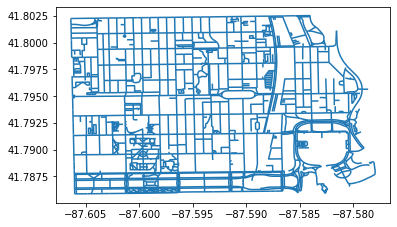

In [11]:
osm_map = gpd.read_file('source/edges.shp')
osm_map.plot()

In [12]:
osm_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         2057 non-null   int64   
 1   v         2057 non-null   int64   
 2   key       2057 non-null   int64   
 3   osmid     2057 non-null   object  
 4   highway   2057 non-null   object  
 5   oneway    2057 non-null   int64   
 6   length    2057 non-null   float64 
 7   from      2057 non-null   int64   
 8   to        2057 non-null   int64   
 9   tunnel    44 non-null     object  
 10  access    30 non-null     object  
 11  name      822 non-null    object  
 12  lanes     134 non-null    object  
 13  service   296 non-null    object  
 14  ref       5 non-null      object  
 15  maxspeed  15 non-null     object  
 16  bridge    5 non-null      object  
 17  width     1 non-null      object  
 18  geometry  2057 non-null   geometry
dtypes: float64(1), geometry(1), int64(6), ob

In [56]:
print(osm_map.osmid.head())
print(osm_map.u.head())
print(osm_map.v.head())
print(osm_map['from'].head())
print(osm_map.to.head())


0                             24925373
1                             24925373
2    [770784627, 770784628, 112726445]
3                            112726441
4               [231646928, 231646933]
Name: osmid, dtype: object
0    1280745481
1    1280745481
2    1280745481
3    1280745484
4    1280745484
Name: u, dtype: int64
0    1393813947
1     270859446
2     270860773
3     269711843
4     269711478
Name: v, dtype: int64
0    1393813947
1     270859446
2     270860773
3     269711843
4     269711478
Name: from, dtype: int64
0    1280745481
1    1280745481
2    1280745481
3    1280745484
4    1280745484
Name: to, dtype: int64


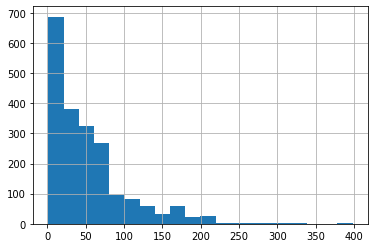

In [13]:
#osm_map_flt['osmid']
#osm_map_flt['geometry'].iloc[0]
valid = (osm_map['length'] < 500)
osm_map.loc[valid, 'length'].hist(bins=20)

In [14]:
len_4326 = []
len_meter = []
num_coords = []

for index, row in osm_map.iterrows():
  line = row['geometry']
  num_coords.append(len(line.coords))
  len_4326.append(line.length)
  len_meter.append(row['length']) # in meters

In [15]:
quick_df = pd.DataFrame({'num_coords': num_coords, 'len_4326':len_4326, 'len_meter':len_meter})
quick_df['ratio'] = quick_df['len_4326'] / quick_df['len_meter']

In [16]:
quick_df.describe()

,num_coords,len_4326,len_meter,ratio
count,2057.000000,2057.000000,2057.000000,2057.000000
mean,3.027710,0.000554,53.106977,0.000011
std,2.501111,0.000546,53.647949,0.000001
min,2.000000,0.000014,1.144000,0.000009
25%,2.000000,0.000151,14.899000,0.000009
50%,2.000000,0.000395,39.403000,0.000011
75%,3.000000,0.000761,67.473000,0.000012
max,32.000000,0.009335,990.457000,0.000012


In [22]:
def sample_points(shapefile, sample_dist, verbose=False):

  # load the shape file: should be edges
  osm_map = gpd.read_file(shapefile)

  # filter the load
  flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ',
              'pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk',
              'secondary','secondary_link','tertiary_link','bridleway','service']

  # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
  flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)
  osm_map_flt = osm_map[flt_idx]
  if verbose:
    print('Filtering done: all rows', len(flt_idx), ', after: ', sum(flt_idx))

  # get bearing for each road
  #osm_map_flt['bearing'] = osm_map_flt['geometry'].apply(lambda line: round(ox.bearing.get_bearing(line.coords[0], line.coords[1])))

  # get the minimum distance in EPSG:4326
  ratio = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    ratio.append(line.length / row['length'])
  sample_dist_4326 = sample_dist * sum(ratio) / len(ratio)

  # sampling the points
  count = 0
  results = []
  for index, row in osm_map_flt.iterrows():
    line = row['geometry']
    results.extend([
      line.interpolate(dist) #[line.interpolate(dist), row['osmid']]
      for dist in arange(sample_dist_4326/2, line.length, sample_dist_4326)
    ])

    count += 1
    if verbose & (count % 1000 == 0):
      print('Processed: ', count, ', points: ', len(results))

  if verbose:
    print('Processed (done): ', count, ', points: ', len(results))

  return results


In [23]:
%timeit points = sample_points('source/edges.shp', 50)

1 loop, best of 3: 234 ms per loop


In [24]:
picked_gdf = gpd.GeoSeries(points)
picked_gdf.head()

0    POINT (-87.58179 41.79279)
1    POINT (-87.58127 41.79273)
2    POINT (-87.58070 41.79268)
3    POINT (-87.58071 41.79238)
4    POINT (-87.58438 41.78869)
dtype: geometry

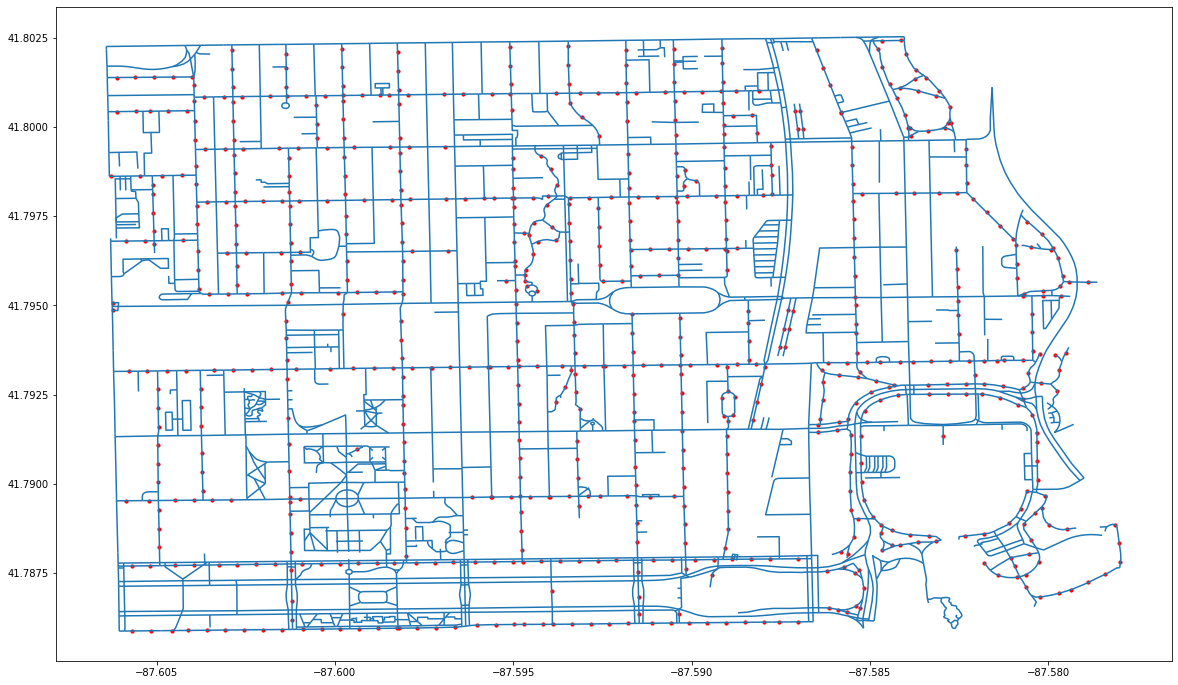

In [25]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)

In [ ]:
# save to file
#picked_gdf.to_csv('drive/My Drive/StreetPsych/' + location + '/seed_' + location + '.csv')

In [ ]:
points_list = [[point.coords[0][1], point.coords[0][0]] for point in points]

In [ ]:
picked_df = pd.DataFrame(points_list, columns=['lat', 'lng'])
picked_df

,lat,lng
0,41.792792,-87.581787
1,41.792728,-87.581267
2,41.792679,-87.580695
3,41.792377,-87.580708
4,41.788694,-87.584384
...,...,...
741,41.796734,-87.602767
742,41.797259,-87.602779
743,41.797784,-87.602792
744,41.795585,-87.602745


In [ ]:
picked_df.to_csv('drive/My Drive/StreetPsych/' + location + '/seed_' + location + '.csv')

# Checking the GSV coordinates vs. original samples

In [27]:
combined_df = pd.read_csv('drive/My Drive/StreetPsych/' + location + '/gsv_seed_' + location + '.csv')
combined_df.head()

,Unnamed: 0,lat,lng,gsv_lat,gsv_lng,pano_id,date,status
0,0,41.792792,-87.581787,41.792797,-87.581747,GHRFbz2JAAvkDmWHU7oswA,2011-06,OK
1,1,41.792728,-87.581267,41.792710,-87.581160,ufrhNaqGu6SQVbLVgT_w_w,2011-06,OK
2,2,41.792679,-87.580695,41.792663,-87.580698,rmTZpVzJqkcAral9_UzfPg,2011-06,OK
3,3,41.792377,-87.580708,41.792374,-87.580722,-Z3wT0T0Sn19i9OVckmarQ,2011-06,OK
4,4,41.788694,-87.584384,41.788709,-87.584438,NHK-F6UQHj8uusHBPq84EQ,2011-06,OK


In [41]:
sum(combined_df['date'] > '2019-01')

606

In [30]:
geometry = [Point(xy) for xy in zip(combined_df['gsv_lng'], combined_df['gsv_lat'])]

In [33]:
#osm_map.crs
gsv_gdf = gpd.GeoDataFrame(combined_df, geometry=geometry)

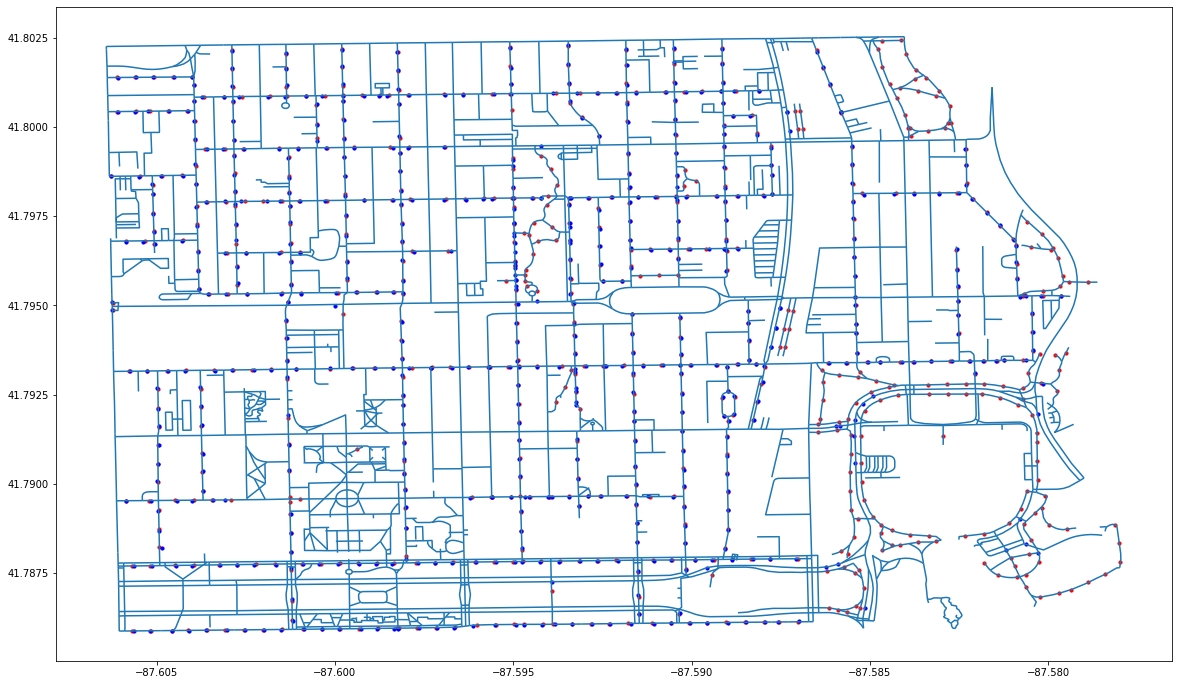

In [42]:
fig, ax = plt.subplots(figsize=(20,20))

osm_map.plot(ax=ax)
picked_gdf.plot(ax=ax, color='red', markersize=10)
gsv_gdf[gsv_gdf['date'] > '2019-01'].plot(ax=ax, color='blue', markersize=10)